## Практическое задание к уроку 10 по теме "Машинный перевод. Модель seq2seq и механизм внимания".

*Разобраться с моделью перевода (без механизма внимания) как она устроена, запустить для перевода с русского на английский (при желании можно взять другие пары языков)*

В данном практическом задании напишу и обучу модель перевода с русского на английский  
на библиотеке pytorch. Добавлю в неё механизм внимания, так как это сложнее и интереснее,  
а также рекуррентную сеть энкодера сделаю двунаправленной.

Загрузим библиотеки:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import re
from time import time
import torch
from torch import nn

In [2]:
RANDOM_STATE = 29

Напишем функцию для обработки текстов:

In [3]:
def preprocess_sentence(w):
    
    # Приведение к нижнему регистру, удаление пробельных символов по краям
    w = w.lower().strip()

    # Обрамление пунктуации пробелами
    w = re.sub("([?.!,;])", r" \1 ", w)

    # Заменяем всё, не являющееся буквами и наиболее частой пунктуацией, пробелами.
    # Также в тексте есть гласные с расставленными ударениями, не будем их терять
    w = re.sub("[^a-zA-Zа-яА-ЯёЁÁáÓóÉéýи́ы́э́ю́я́?.!,;']+", " ", w)
    w = w.strip()
    
    # Добавим обозначения начала и конца строки
    # На момент сдачи ДЗ github не отображает строки индексов начала и конца предложения start и end
    w = '<start> ' + w + ' <end>'
    
    return w

Загрузим текст для обучения:

In [4]:
with open('../../Теория/Lesson_10/data/rus.txt', 'r', encoding='utf-8') as f:
    lines = f.read().strip().split('\n')
    
word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines]

y_lang, x_lang = zip(*word_pairs)

In [5]:
print(x_lang[0]) 
print(y_lang[0])

<start> марш ! <end>
<start> go . <end>


In [6]:
len(x_lang), len(y_lang)

(451436, 451436)

По сравнению с уроком, оставлю все строки текста для более  
качественного обучения.

Напишем функцию для подготовки словарей маппинга:

In [7]:
def get_vocabs(lang):
    corpus = ' '.join(w for w in lang)
    vocab = set(corpus.split())
    char2idx = {w: i for i, w in enumerate(vocab, 1)}
    idx2char = {i: w for w, i in char2idx.items()}
    
    return char2idx, idx2char, len(vocab) + 1

Подготовим словари для обоих языков:

In [8]:
x_char2idx, x_idx2char, x_vocab_size = get_vocabs(x_lang)
y_char2idx, y_idx2char, y_vocab_size = get_vocabs(y_lang)

Посмотрим на распределение длин предложений для выбора фиксированной  
длины:

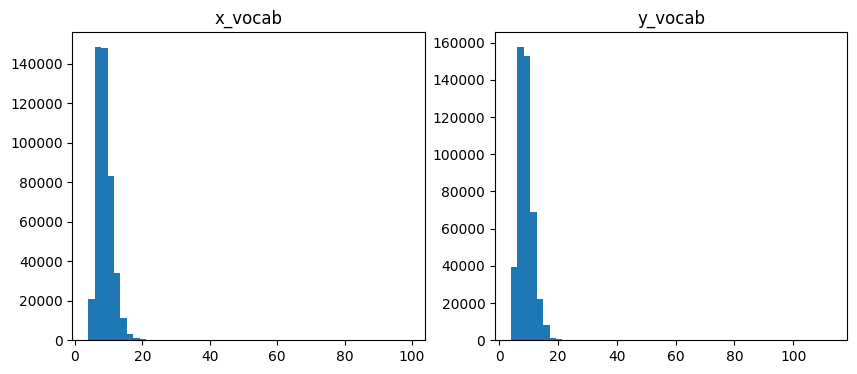

In [9]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist([len(x.split()) for x in x_lang], bins=50)
plt.title('x_vocab')

plt.subplot(1, 2, 2)
plt.hist([len(y.split()) for y in y_lang], bins=50)
plt.title('y_vocab')

plt.show()

Длины 20 должно хватить для текстов на обоих языках:

In [10]:
MAX_LEN = 20

Переведём тексты в последовательности индексов фиксированной  
длины:

In [11]:
def text_to_seq(text, vocab):
    seq = []
    for token in text.split():
        if token in vocab:
            seq.append(vocab[token])
    padding = [0] * (MAX_LEN - len(seq))
    return seq[:MAX_LEN] + padding

In [12]:
X = np.array([text_to_seq(text, x_char2idx) for text in x_lang])
Y = np.array([text_to_seq(text, y_char2idx) for text in y_lang])

In [13]:
X

array([[35561,  3718, 29947, ...,     0,     0,     0],
       [35561, 54427, 39683, ...,     0,     0,     0],
       [35561, 29261, 39683, ...,     0,     0,     0],
       ...,
       [35561, 25817, 19729, ...,  1447, 36934, 22803],
       [35561, 40351, 24722, ..., 49237, 18724, 45154],
       [35561, 56694, 45154, ..., 11866, 46687,  3719]])

In [14]:
Y

array([[ 7974,  7227, 13050, ...,     0,     0,     0],
       [ 7974,  7227, 13050, ...,     0,     0,     0],
       [ 7974,  7227, 13050, ...,     0,     0,     0],
       ...,
       [ 7974,  2266, 16237, ...,  7013,  4935, 16026],
       [ 7974,  4011,  7892, ..., 12074,  4415,  4029],
       [ 7974,  4799, 16237, ..., 14649, 15258, 10471]])

Напишем стандартный класс датасета и обернём его в даталоадер:

In [15]:
class DataWrapper(torch.utils.data.Dataset):
    def __init__(self, data, target):
        self.data = torch.from_numpy(data)
        self.target = torch.from_numpy(target)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [16]:
BATCH_SIZE = 128

In [17]:
torch.random.manual_seed(RANDOM_STATE)

dataset = DataWrapper(X, Y)

loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True)

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Теперь напишем классы сети. Начнём со слоя внимания:

In [19]:
class AttentionLayer(nn.Module):
    def __init__(self, units=32, hidden_size=512):
        super().__init__()
        
        # Переводим векторы скрытых состояний в векторы одинаковой длины
        # с помощью линейных слоёв
        self.W1 = nn.Linear(hidden_size, units)
        
        # Так как рекуррентная сеть энкодера двунаправленная,  
        # то вектор скрытого состояния у неё удвоенной длины
        self.W2 = nn.Linear(2 * hidden_size, units)
        
        # По итогу, для каждого токена, приходящего на энкодер 
        # будем получать одну оценку внимания
        self.V = nn.Linear(units, 1)
        
    def forward(self, dec_hidden, enc_output):
        
        # Оценка каждого токена, поступающего на энкодер, исходя из близости состояния  
        # соответствующей ячейки рекуррентной сети энкодера и текущего состояния декодера
        score = self.V(torch.tanh(self.W1(dec_hidden) + self.W2(enc_output))) # (batch_size, MAX_LEN, 1)
        
        # Нормализуем оценку софтмаксом, получим веса
        attention_weights = torch.softmax(score, dim=1) # (batch_size, MAX_LEN, 1)
        
        # Умножим веса на выходы соответствующих ячеек энкодера, получим взвешенные векторы  
        # контекста для каждой ячейки. Затем сложим все эти векторы, получим своеобразный  
        # взвешенный эмбеддинг всего предложения
        context_vector = attention_weights * enc_output # (batch_size, MAX_LEN, 2 * hidden_size)
        context_vector = torch.sum(context_vector, dim=1, keepdim=True) # (batch_size, 1, 2 * hidden_size)
        return context_vector

Напишем энкодер, слой GRU двунаправленный:

In [20]:
class Encoder(nn.Module):
    def __init__(self, embed_dim=256, hidden_size=512):
        super().__init__()
        self.embedding = nn.Embedding(x_vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, x):

        x = self.embedding(x)
        output, state = self.gru(x)
        
        # Так как далее мы передаём вектор скрытого состояния  
        # на декодер, а рекуррентная сеть декодера - однонаправленная,  
        # чтобы не "заглядывать" в будущее, то нужно привести резмерность  
        # вектора к однонаправленной. Для этого будем брать максимальные  
        # значения из обоих направлений
        state, _ = torch.max(state, dim=0, keepdim=True)
        
        return output, state

Напишем декодер. Слой GRU принимает на вход сконкатенированный вектор,  
состоящий из эмбеддинга входящего токена и вектора контекста после слоя внимания.

In [21]:
class Decoder(nn.Module):
    def __init__(self, attention_units=32, embed_dim=256, hidden_size=512):
        super().__init__()
        self.attention = AttentionLayer(units=attention_units, hidden_size=hidden_size)
        self.embedding = nn.Embedding(y_vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim + 2 * hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, y_vocab_size)
        
    def forward(self, x, state, enc_output):
        state = state.permute(1, 0, 2)
        context_vector = self.attention(state, enc_output)
        x = self.embedding(x)
        x = torch.cat((context_vector, x), dim=-1)
        output, state = self.gru(x)
        output = torch.squeeze(output)
        output = self.fc(output)
        
        return output, state

Напишем функцию обучения сети:

In [22]:
def train_nn(epochs=5, embed_dim=256, hidden_dim=512, lr=1e-3):
    
    torch.random.manual_seed(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True

    encoder = Encoder(embed_dim=embed_dim, hidden_size=hidden_dim).to(device)
    decoder = Decoder(embed_dim=embed_dim, hidden_size=hidden_dim).to(device)

    param_groups = [
    {'params': encoder.parameters(), 'lr': lr},
    {'params': decoder.parameters(), 'lr': lr}
]
    optimizer = torch.optim.Adam(param_groups)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        
        start_time = time()
        batch_losses = np.array([])
        
        for inputs, targets in loader:
            loss = 0
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            
            enc_output, enc_hidden = encoder(inputs)
            
            # Первым входом декодера является индикатор начала предложения
            # На момент сдачи ДЗ github не отображает строку индекса начала предложения start
            dec_input = torch.IntTensor([y_char2idx['<start>']] * len(inputs)).reshape(-1, 1).to(device)
            
            # Первым вектором скрытого состояния декодера является последний  
            # вектор скрытого состояния энкодера
            dec_hidden = enc_hidden.detach().clone().requires_grad_(True)
            
            # Подаём на декодер токены по одному
            for t in range(1, MAX_LEN):
                preds, dec_hidden = decoder(dec_input, dec_hidden, enc_output)
                loss += criterion(preds, targets[:, t])
                
                # Входами декодера будут являться фактические токены из 
                # обучающего текста, а не предсказанные
                dec_input = targets[:, t].reshape(-1, 1)
            
            loss.backward()
            optimizer.step()

            batch_losses = np.append(batch_losses, loss.item() / t)

        print(f'Epoch [{epoch + 1}/{epochs}]. ' \
              f'Loss: {batch_losses.mean():.3f}. ' \
              f'Time: {round(time() - start_time)} sec.')

    print('Training is finished!')
    return encoder, decoder

Обучим сеть. Вернём энкодер и декодер, так как они оба потребуются  
для перевода текстов:

In [23]:
enc_model, dec_model = train_nn(epochs=15)

Epoch [1/15]. Loss: 0.897. Time: 238 sec.
Epoch [2/15]. Loss: 0.419. Time: 241 sec.
Epoch [3/15]. Loss: 0.305. Time: 240 sec.
Epoch [4/15]. Loss: 0.242. Time: 239 sec.
Epoch [5/15]. Loss: 0.204. Time: 239 sec.
Epoch [6/15]. Loss: 0.176. Time: 239 sec.
Epoch [7/15]. Loss: 0.155. Time: 239 sec.
Epoch [8/15]. Loss: 0.141. Time: 239 sec.
Epoch [9/15]. Loss: 0.133. Time: 239 sec.
Epoch [10/15]. Loss: 0.121. Time: 249 sec.
Epoch [11/15]. Loss: 0.117. Time: 265 sec.
Epoch [12/15]. Loss: 0.111. Time: 247 sec.
Epoch [13/15]. Loss: 0.107. Time: 240 sec.
Epoch [14/15]. Loss: 0.106. Time: 240 sec.
Epoch [15/15]. Loss: 0.102. Time: 241 sec.
Training is finished!


Напишем функцию для перевода:

In [24]:
def translate(ru_text):
    with torch.no_grad():

        en_text = ''

        # Предобработаем входной текст
        ru_text_processed = preprocess_sentence(ru_text)
        
        # Переводим входной текст в набор индексов фиксированной длины
        ru_text_idx = torch.IntTensor([text_to_seq(ru_text_processed, x_char2idx)]).reshape(1, -1).to(device)
        
        enc_output, enc_hidden = enc_model(ru_text_idx)

        dec_hidden = enc_hidden.detach().clone()
        
        # На момент сдачи ДЗ github не отображает строку индекса начала предложения start
        dec_input = torch.IntTensor([y_char2idx['<start>']]).reshape(1, -1).to(device)

        for t in range(MAX_LEN):
            translated, dec_hidden = dec_model(dec_input, dec_hidden, enc_output)
            
            # Всегда берём наиболее вероятное слово. Для большего разнообразия 
            # и исключения закольцовывания сгенерированного текста можно использовать  
            # температуру и взвешенную случайную выборку, как на прошлом уроке,  
            # но это ещё больше усложнит код
            en_idx = torch.argmax(translated)
            
            en_char = y_idx2char[en_idx.item()]
            
            # Прекращаем перевод при достижении индикатора конца предложения
            # На момент сдачи ДЗ github не отображает строку индекса конца предложения end
            if en_char == '<end>':
                break
                
            en_text = en_text + en_char + ' '
    
            # На вход декодера подаём теперь предсказанные токены
            dec_input = en_idx.reshape(1, -1)
            
    print(f'Текст на русском:\t\t{ru_text}\n'
          f'Его перевод на английский:\t{en_text}')

Визуально оценим качество модели:

In [25]:
translate('Доброе утро!')

Текст на русском:		Доброе утро!
Его перевод на английский:	good morning ! 


In [26]:
translate('Приятно познакомиться.')

Текст на русском:		Приятно познакомиться.
Его перевод на английский:	it's a pleasure to meet you . 


In [27]:
translate('Помогите, пожалуйста!')

Текст на русском:		Помогите, пожалуйста!
Его перевод на английский:	help me , please ! 


In [28]:
translate('Вы говорите по-русски?')

Текст на русском:		Вы говорите по-русски?
Его перевод на английский:	do you speak russian ? 


In [29]:
translate('Что нужно делать?')

Текст на русском:		Что нужно делать?
Его перевод на английский:	what do you have to do ? 


In [30]:
translate('На улице всё ещё идёт дождь.')

Текст на русском:		На улице всё ещё идёт дождь.
Его перевод на английский:	it's still raining outside . 


In [31]:
translate('У кого можно узнать, когда следующий поезд?')

Текст на русском:		У кого можно узнать, когда следующий поезд?
Его перевод на английский:	can i have a minute , can the next train ? 


In [32]:
translate('Вселенная настолько велика, что ничего на свете не имеет значения!')

Текст на русском:		Вселенная настолько велика, что ничего на свете не имеет значения!
Его перевод на английский:	the jack of humor is anything worse ! 


С простыми фразами модель справилась хорошо. Фразы посложнее вызывают  
определённые проблемы. Это может быть вызвано комбинацией следующих  
причин:  
- не хватило эпох обучения;  
- недостатки архитектуры сети;  
- "бедность" обучающего датасета;  
- некачественная предобработка текста.

Несмотря на это, мы написали и обучили работающий переводчик  
с русского на английский. Задача выполнена.